<a href="https://www.kaggle.com/code/nishantpatel54/30day-stock-forecast-lstm?scriptVersionId=145421030" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.0/928.0 kB 16.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for peewee: filename=peewee-3.16.3-cp310-cp310-linux_x86_64.whl size=314460 sha256=ed8fe019f48192ef18e93db8734557fcde7215f37038c6ef41bdb7c812266766
  Stored in directory: /root/.cache/pip/wheels/c8/ac/6d/ad6d828725ffbe3abc508c95d25dd0c5fcc63539ae47913790
Successfully built peewee


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
ticker = 'TSLA'
lookback = 50
forecast = 30
dataset = yf.download(ticker, period='5y')
# dataset_val = yf.download(ticker, start='2023-06-03')
train_set = dataset[['Close']].fillna(method='ffill')
train_set = train_set.values.reshape(-1,1)
# val_set = dataset_val[['Close']].fillna(method='ffill').head(lookback+forecast)
# val_set = val_set.values.reshape(-1,1)
# val_set.shape, train_set.shape

[*********************100%%**********************]  1 of 1 completed


In [3]:
sc = MinMaxScaler(feature_range=(0,1))
sc = sc.fit(train_set)
train_set_scaled = sc.transform(train_set)

# sc_val = MinMaxScaler(feature_range=(0,1))
# sc_val = sc_val.fit(val_set)
# val_set_scaled = sc_val.transform(val_set)
# val_set_scaled[:10], 
train_set_scaled[:10]

array([[0.01199046],
       [0.01404051],
       [0.01304899],
       [0.01227016],
       [0.01336721],
       [0.01350288],
       [0.01635017],
       [0.01554456],
       [0.01422643],
       [0.01357154]])

In [4]:
X_train=[]
y_train=[]
# X_val=[]
# y_val=[]

for i in range(lookback, len(train_set_scaled) - forecast + 1):
    X_train.append(train_set_scaled[i - lookback : i])
    y_train.append(train_set_scaled[i : i + forecast])

# for i in range(lookback, len(val_set_scaled) - forecast + 1):
#     X_val.append(val_set_scaled[i - lookback : i])
#     y_val.append(val_set_scaled[i : i + forecast])
    
X_train=np.array(X_train)
y_train=np.array(y_train)
# X_val=np.array(X_val)
# y_val = np.array(y_val)


In [5]:
#model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(forecast))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [6]:
#train

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
37/37 [==============================] - 12s 117ms/step - loss: 0.0889
Epoch 2/100
37/37 [==============================] - 4s 117ms/step - loss: 0.0262
Epoch 3/100
37/37 [==============================] - 4s 118ms/step - loss: 0.0202
Epoch 4/100
37/37 [==============================] - 4s 122ms/step - loss: 0.0172
Epoch 5/100
37/37 [==============================] - 4s 118ms/step - loss: 0.0157
Epoch 6/100
37/37 [==============================] - 4s 119ms/step - loss: 0.0144
Epoch 7/100
37/37 [==============================] - 4s 120ms/step - loss: 0.0132
Epoch 8/100
37/37 [==============================] - 4s 121ms/step - loss: 0.0128
Epoch 9/100
37/37 [==============================] - 4s 121ms/step - loss: 0.0120
Epoch 10/100
37/37 [==============================] - 4s 119ms/step - loss: 0.0114
Epoch 11/100
37/37 [==============================] - 5s 123ms/step - loss: 0.0107
Epoch 12/100
37/37 [==============================] - 4s 120ms/step - loss: 0.0105
Epoch 13/100

[255.71000671 266.44000244 267.42999268 261.07000732 254.11000061
 259.32000732 253.86000061 251.44999695 249.69999695 242.19000244
 245.33999634 242.6499939  239.75999451 232.96000671 225.6000061
 219.22000122 215.49000549 231.27999878 233.19000244 236.86000061
 230.03999329 238.58999634 238.82000732 257.17999268 256.8999939
 258.07998657 245.00999451 256.48999023 251.91999817 251.49000549
 248.5        273.57998657 267.48001099 271.29998779 276.04000854
 274.39001465 265.27999878 266.5        262.58999634 255.69999695
 244.88000488 246.99000549 244.11999512 240.5        246.38000488
 250.22000122 251.6000061  246.52999878 261.16000366 260.04998779]
1/1 [==============================] - 1s 1s/step
[260.04998779 252.8664856  252.80926514 254.03652954 255.88520813
 254.68486023 254.54408264 256.44418335 255.72909546 254.51716614
 255.8625946  256.72546387 258.58724976 256.23962402 256.82006836
 255.85720825 258.12347412 256.78063965 259.3291626  255.57221985
 257.12188721 258.23440552 

/tmp/ipykernel_20/2260421488.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_past['Forecast'].iloc[-1] = dataset_past['Actual'].iloc[-1]


<Axes: title={'center': 'ticker'}, xlabel='Date'>

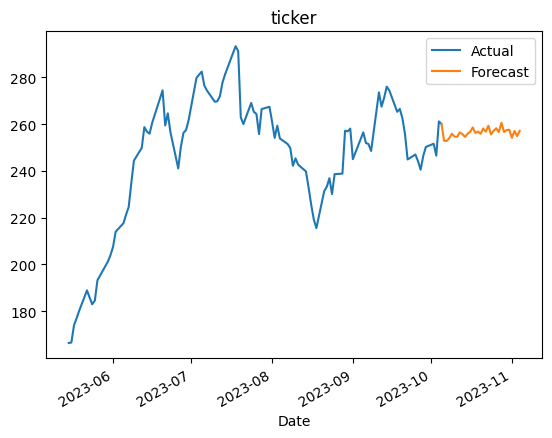

In [7]:
X_ = train_set_scaled[-lookback:]
print(sc.inverse_transform(X_).flatten())
X_ = X_.reshape(1, lookback, 1)

y_ = model.predict(X_).reshape(-1,1)
y_ = sc.inverse_transform(y_)

dataset_past = dataset[['Close']].reset_index()
dataset_past.rename(columns={'index':'Date','Close':'Actual'},inplace=True)
dataset_past['Date'] = pd.to_datetime(dataset_past['Date'])
dataset_past['Forecast'] = np.nan
dataset_past['Forecast'].iloc[-1] = dataset_past['Actual'].iloc[-1]

dataset_future = pd.DataFrame(columns=['Date','Actual','Forecast'])
dataset_future['Date'] = pd.date_range(start=dataset_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods = forecast)
dataset_future['Actual'] = np.nan
dataset_future['Forecast'] = y_.flatten()

actual_preds = pd.concat([dataset_past[-100:], dataset_future], ignore_index=True)
actual_preds=actual_preds.set_index('Date')
print(actual_preds['Forecast'].dropna().values.flatten())
actual_preds.plot(title='ticker')